In [11]:
import pandas as pd
import numpy as np

In [12]:
sales_of_company_x = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("Series/international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("Series/daily-total-female-births-in-cal.csv")

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
dowjones_closing.head()

,Week,Close
0,1971-W27,890.19
1,1971-W28,901.80
2,1971-W29,888.51
3,1971-W30,887.78
4,1971-W31,858.43


In [15]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

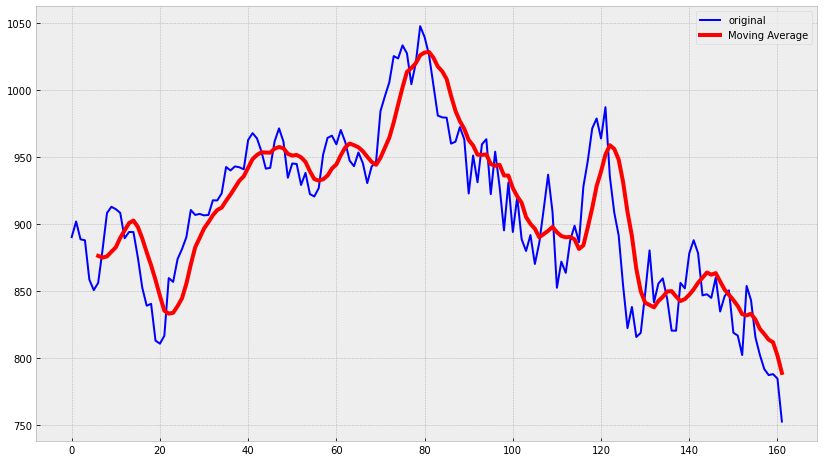

In [16]:
ser = moving_average(dowjones_closing["Close"], 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(dowjones_closing["Close"], color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

In [17]:
train, test = dowjones_closing["Close"][:110], dowjones_closing["Close"][110:]

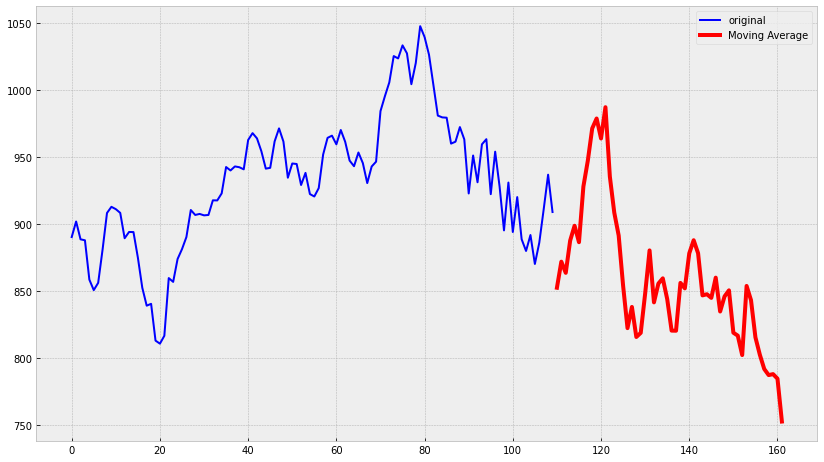

In [18]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(train, color='blue',label='original')
    plt.plot(test, color='red', linewidth='4', label='Moving Average')
    plt.legend()

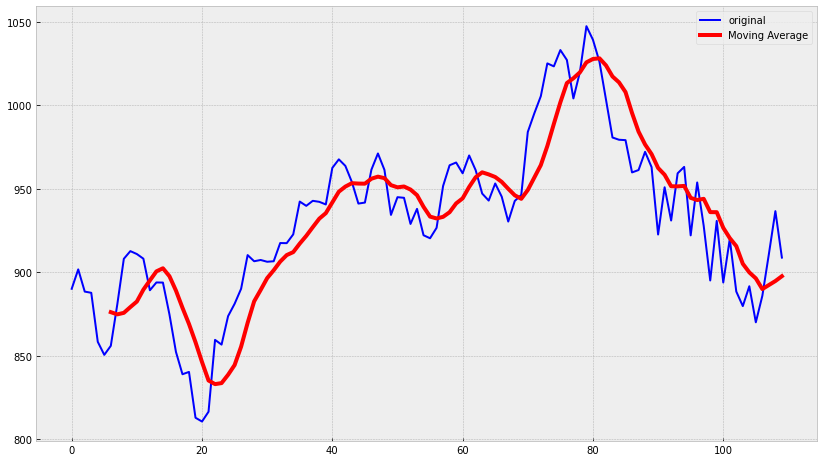

In [19]:
ser = moving_average(train, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(train, color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

In [20]:
def initial_trend(series, season_len, i):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen, i)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

def plot_tema(alpha, beta, gamma, ser=sales_of_company_x["Count"], ser_to_plot=sales_of_company_x["Count"], n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='train')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.plot(test, color='green', linewidth='2', label='test2')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

Без обучения параметров

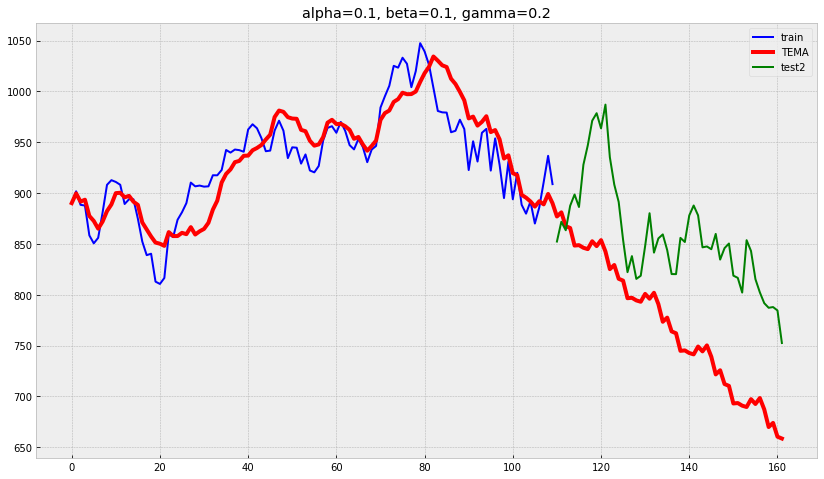

In [21]:
plot_tema(0.1, 0.1, 0.2, train, train, len(test))

TEMA с обученными параметрами

In [106]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [165]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 4, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [175]:
np.random.seed(46)
opt = minimize(mse, x0=np.random.rand(3), method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [176]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 1318.8085501131425
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.18628725, -0.11934844, 32.76729785])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 200
      nit: 37
     njev: 50
   status: 0
  success: True
        x: array([0.75187434, 0.75251242, 0.        ])


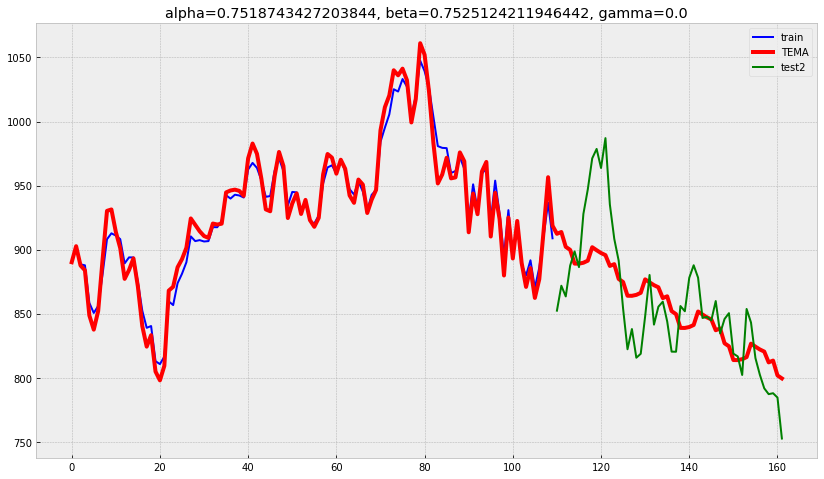

In [177]:
plot_tema(alpha_opt, beta_opt, gamma_opt, train, train, len(test))

DEMA без обученных параметров, подходит только для сглаживания

In [133]:
def double_ema_with_preds(series, alpha, beta, n_preds):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        
    preds = []
    for n in range(n_preds):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)

    return series.append(pd.Series(preds), ignore_index=True), pd.Series(result)

/var/folders/cx/_5xjkh393jx_2qr3xdd7vkx80000gn/T/ipykernel_1870/2601243732.py:18: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return series.append(pd.Series(preds), ignore_index=True), pd.Series(result)


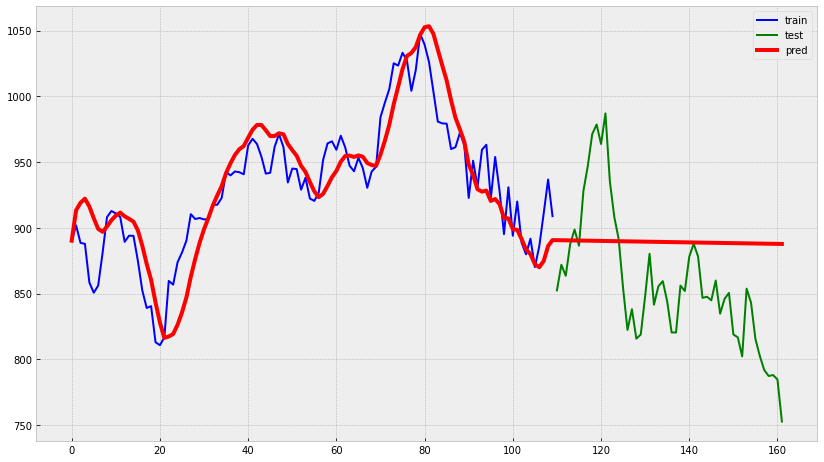

In [145]:
pred = double_ema_with_preds(train, 0.2, 0.2, len(test))
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(train, color='blue',label='train')
    plt.plot(test, color='green',label='test')
    plt.plot(pred[1], color='red', linewidth='4', label='pred')
    plt.legend()

In [154]:
def mse2(X):
    alpha, beta = X
    result = double_ema_with_preds(train, alpha, beta, len(test))[1]
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [155]:
np.random.seed(44)
opt2 = minimize(mse2, x0=np.random.rand(2), method="L-BFGS-B", bounds = ((0, 1), (0, 1)))

/var/folders/cx/_5xjkh393jx_2qr3xdd7vkx80000gn/T/ipykernel_1870/2601243732.py:18: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return series.append(pd.Series(preds), ignore_index=True), pd.Series(result)
/var/folders/cx/_5xjkh393jx_2qr3xdd7vkx80000gn/T/ipykernel_1870/2601243732.py:18: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return series.append(pd.Series(preds), ignore_index=True), pd.Series(result)
/var/folders/cx/_5xjkh393jx_2qr3xdd7vkx80000gn/T/ipykernel_1870/2601243732.py:18: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return series.append(pd.Series(preds), ignore_index=True), pd.Series(result)
/var/folders/cx/_5xjkh393jx_2qr3xdd7vkx80000gn/T/ipykernel_1870/2601243732.py:18: FutureWarning: The series.append 

In [156]:
alpha_opt2, beta_opt2 = opt2.x
print(opt2)

      fun: 1645.0552716247437
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2609.06054844,     0.        ])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 42
      nit: 12
     njev: 14
   status: 0
  success: True
        x: array([1.        , 0.06357302])


DEMA с оубченными параметрами, фиксирует тренд на снижение.

/var/folders/cx/_5xjkh393jx_2qr3xdd7vkx80000gn/T/ipykernel_1870/2601243732.py:18: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return series.append(pd.Series(preds), ignore_index=True), pd.Series(result)


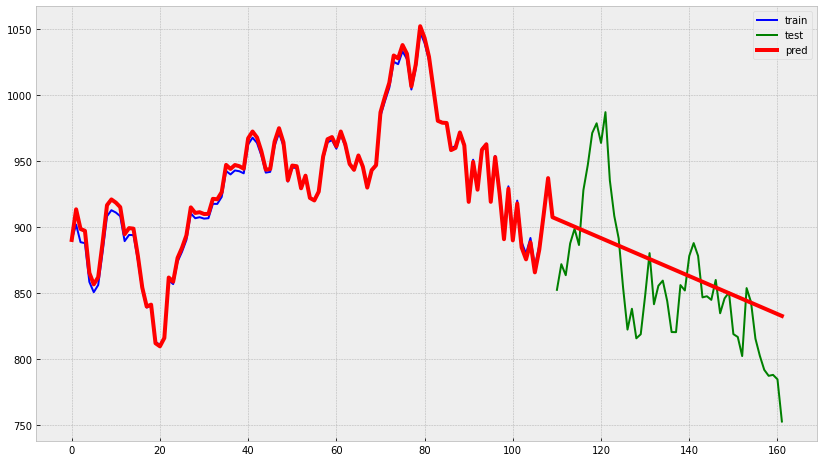

In [157]:
pred = double_ema_with_preds(train, alpha_opt2, beta_opt2, len(test))
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(train, color='blue',label='train')
    plt.plot(test, color='green',label='test')
    plt.plot(pred[1], color='red', linewidth='4', label='pred')
    plt.legend()

---

Обучение TEMA на ряду привиденного к станционатному виду.

In [180]:
st_series = np.array(dowjones_closing["Close"])
st_series = st_series[4:] - st_series[:-4]
train, test = st_series[:110], st_series[110:]

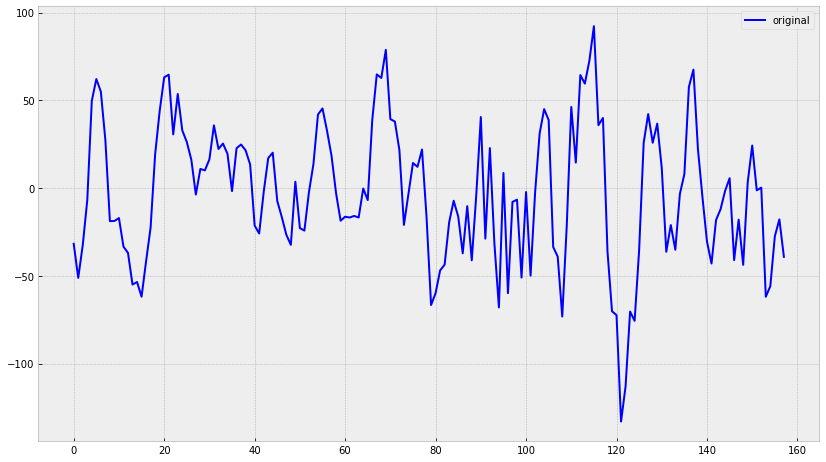

In [182]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(st_series, color='blue',label='original')
    plt.legend()

In [183]:
np.random.seed(46)
opt = minimize(mse, x0=np.random.rand(3), method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 2197.495345558383
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.28376235, 0.03260539, 0.01914486])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 348
      nit: 48
     njev: 87
   status: 0
  success: True
        x: array([0.0708309 , 0.46413439, 0.01784739])


Со сглаживанием у модели есть явные проблемы, но более меннее правильно предсказывает моменты когда происходят скачки

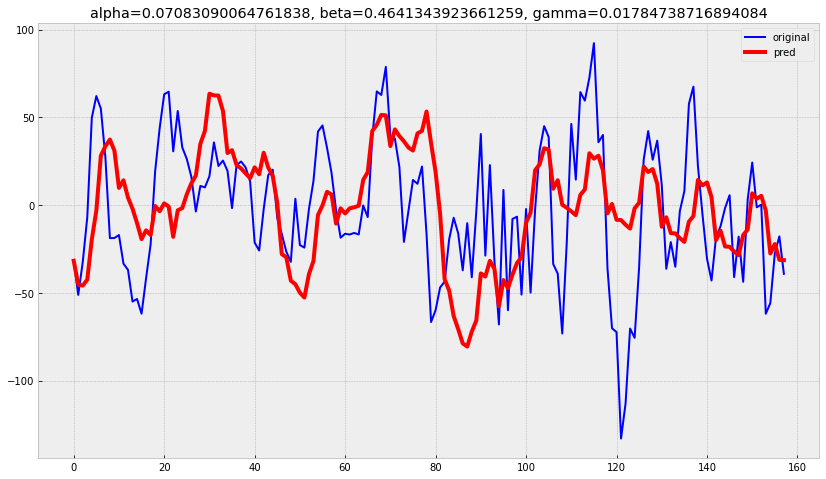

In [190]:
tema = triple_exponential_smoothing(train, 12, alpha_opt, beta_opt, gamma_opt, len(test))
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(st_series, color='blue',label='original')
    plt.plot(tema, color='red', linewidth='4', label='pred')
    plt.title("alpha={}, beta={}, gamma={}".format(alpha_opt, beta_opt, gamma_opt))
    plt.legend()